### Tutorial 6.2

We will continue with the example of [section 6.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/6%20Modeling%20stoichiometry%20variations/Oxygen%20starvation%20in%20batch%20fermenters.ipynb). Below the physiological properties of the microbe as given before:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$| $(P/O)$ $\qquad \qquad$
|----|-|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$|$\frac{mol\,ATP}{mol\, O}$
|0.1|2.5|0.3|0.1|1.5

The biomass formula is given by $CH_{1.8}O_{0.5}N_{0.2}$

The following Monod characteristics are known:

|$K_M\left[\frac{mg}{L} \right] \qquad$ |
 -|-
 **Growth**|30 
**Maintenance**|5 

Since only $CO_2$ will be formed as product, zero product inhibition is present. The following conditions are specified for the batch fermenter:

|V [$L$]|$C_X^o \left[ \frac{g}{L}\right]$|$C_S^o \left[ \frac{g}{L}\right]$
|-------------|-------|------
|2000|0.025 $\qquad$|150 $\qquad$

We can now define the parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
from scipy.integrate import solve_ivp
α, γ, μ_max, θ_max, PO = 0.1, 2.5, 0.3, 0.1, 1.5
Km_μ, Km_θ = 30/1000/30, 5/1000/30
Mx = 12+1.8+0.5*16+0.2*14
V, Cxo, Cso = 200, 0.025/Mx, 150/30

We can also define $k_La$ and $C_{O_2}^{sat}$ as 200$\frac{1}{h}$ and 7$\frac{mg}{L}$: 

In [2]:
kla = 200
Co_s_max = 7/1000/32  #mol/l

The flux model is given below. Note that carbon splits between biomass and respiration.

<img src="respv2.png" width="700" />

In [3]:
def response_fun(C):
    
    Cx, Cs = C          
    μ = μ_max * Cs / (Km_μ + Cs)
    θ = θ_max * Cs / (Km_θ + Cs)
    
    ro_mt = kla * Co_s_max
    
    Sbase = np.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])
    
    S1 = np.vstack([Sbase,[0,1,0,0,0]])  #Stoich matrix with growth spec
      
    C= np.matrix([[0,0,0,θ, μ]]).T
    r = np.linalg.solve(S1,C)            #rates for regime where no oxygen limitation exist
    
        
    if ro_mt > r[3,0] * Cx:     #no oxygen limitation
        
        return [r[1,0],      #biomass 
                -r[0,0],
                r[4,0],      # CO2 formation
                r[3,0]]      # O2 consumption                                                 
     
    else:
        
        S2 = np.vstack([Sbase,[0,0,0,1,0]])       #Stoich matrix with oxygen spec

        C2 = np.matrix([[0, 0, 0, θ, ro_mt/Cx]]).T   # Note the ro specification!!
        r2 = np.linalg.solve(S2,C2)                 # rates for regime where oxygen limitation exist
        
        
        return [r2[1,0],
               -r2[0,0],
                r2[4,0],    #CO2 formation
                r2[3,0]]    #O2 consumption  

In [4]:
def ferm_eq(t, C):
    Cx, Cs = C[0],C[1]
    r=response_fun([Cx, Cs])     
    
    return [r[0]*Cx,
            r[1]*Cx]    
            

<IPython.core.display.Javascript object>


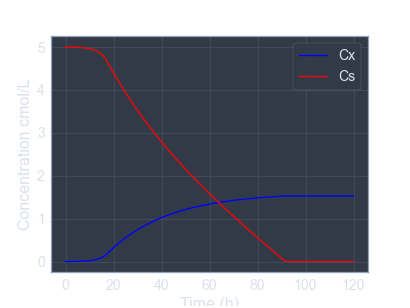

In [5]:
Co = [Cxo, Cso]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax = 120                                   # Integrate for 120 hours  
tspan = np.linspace(0, tmax, 200)           # define the timespan of the integration
Ci = solve_ivp(ferm_eq, [0, tmax], Co, t_eval = tspan, method = 'Radau').y             # integration via solve_ivp that calls apon ferm_eq

Cx, Cs = Ci

plt.figure(2)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('Time (h)') 
plt.show()

a) Determine $[\mu, -r_S, r_{O_2}]$ at 10, 30 and 90 hours. Explain the differences.

(Tip: redefine tspan with 121 elements so that the index corresponds to the time value)

b) What is the minimum value of $r_{O_2}$ for a cell to survive? No integration required. $[0.0272 \frac{mol}{cmol \, X \cdot h}]$

(Tip: Copy the matrix from the response function, alter accordingly and solve the matrix manually (not using any functions).

c) Given the value in (b), that is the maximum possible $C_X$ that the fermenter can sustain. $[1.604 \frac{cmol}{L}]$

(Tip: $r_{O_2}^{mt}=r_{O_2}^V=r_{O_2}C_X$)

d) How does the answer in (c) compare to the final $C_X$ achieved in the fermentation? 

e) Play around by increasing $C_{S}^o$ and the fermentation time. Does the final $C_X$ get closer to the maximum value in (c)?

f) At what point in time is the maximum volumetric supply of oxygen fully utilised? [approx 17 hours]

g) Plot $\mu$ as a function of time. Explain the profile.

h) Determine the fraction of glucose spent on growth at 18 and 80 hours. [94% and 17%]

i) Increase the value of $k_La$ to 600 $\frac{1}{h}$ an plot the results against the original profiles. Explain the difference.



[Back to all tutorials](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/All%20tutorials.ipynb)